In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture
from sklearn.mixture import GaussianMixture

from scipy.stats import kstest
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("Data/base_csv_final.csv")
df

,Author,Title,Year,Themes,Author_Cleaned,index,Texte
0,Alexandre Dumas ...,Pauline,1830,Décadence,Alexandre Dumas,71510,PAULINE ET PASCAL BRUNO ***\n\nAu lecteur\nTab...
1,Alexandre Dumas,Les trois mousquetaires,1830,Décadence,Alexandre Dumas,58211,"LES TROIS MOUSQUETAIRES, VOLUME 2 (OF 2) ***\n..."
2,Alexandre Dumas ...,Gabriel Lambert,1830,Décadence,Alexandre Dumas,46747,GABRIEL LAMBERT ***\n\nThe Project Gutenberg e...
3,Alexandre Dumas ...,Le comte de Moret,1830,Décadence,Alexandre Dumas,37771,LE COMTE DE MORET ***\n\n\nAu lecteur\nBibliot...
4,Alexandre Dumas ...,La tulipe noire,1830,Décadence,Alexandre Dumas,26504,LA TULIPE NOIRE ***\n\n\nAlexandre Dumas\nLA T...
...,...,...,...,...,...,...,...
86,Émile Zola ...,La curée,1885,"Décadence, Société et politique",Émile Zola,17553,LA CURÉE ***\n\n\nÉmile Zola\nLA CURÉE\n(1872)...
87,Émile Zola ...,Le rêve,1885,"Décadence, Société et politique",Émile Zola,17533,LE RÊVE ***\n\n\nÉmile Zola\nLE RÊVE\n(1888)\n...
88,Émile Zola,Au bonheur des dames,1885,"Décadence, Société et politique",Émile Zola,16852,AU BONHEUR DES DAMES ***\nProduced by Ebooks l...
89,Émile Zola ...,Contes à Ninon,1885,"Décadence, Société et politique",Émile Zola,7462,CONTES À NINON ***\nProduced by Sergio Cangian...


In [3]:
df.drop(index=47, inplace=True)
df.reset_index(drop=True, inplace=True)


In [4]:
#for tf_idf
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
#TfIdf
def Tf_Idf (lemmas) :
    
    voc=[]
    for l in lemmas :
        
        voc.extend(l['Lemmes'].tolist())  # Assuming 'Lemmes' column contains the terms
    voc = list(set(voc)) 
    
    vectorizer = TfidfVectorizer(lowercase=False, vocabulary=voc, min_df=2)
    documents = [" ".join(l['Lemmes'].tolist()) for l in lemmas]
    vectorizer.fit(documents)
    vectors=vectorizer.transform(documents)
    """
    vectors=[]
    for l in lemmas :
        X=vectorizer.transform([" ".join(l['Lemmes'].tolist())])
        vectors.append(X)
        """
    return vectors,vectorizer
t_lemmas=[v for k, v in pd.read_parquet('Data/lemmes.parquet', engine='pyarrow').groupby('Id')]+[v for k, v in pd.read_parquet('Data/lemmes_2.parquet', engine='pyarrow').groupby('Id')]
vec,vectorizer=Tf_Idf(t_lemmas)

In [5]:
vectorizer

TfidfVectorizer(lowercase=False, min_df=2,
                vocabulary=['Venceslas', 'Daumier', 'réfracter', 'Rotouma',
                            'Fresne', 'Ténare', 'Greenwich', 'méridional',
                            'encaissement', 'Faïtoka', 'conformé', 'Here',
                            'désorienter', 'dérouter', 'rougeoyer', 'targui',
                            'Kimba', 'Montevideo', 'Ayasé', 'Inachus', 'lapsus',
                            'Pons', 'Proudhon', 'moquerie', 'nièce',
                            'Zagarriga', 'enthousiaste', 'détrompé', 'Carara',
                            'utiliser', ...])

In [6]:
t_lemmas

[            Lemmes  Id
 0          PAULINE   0
 1           pascal   0
 2            BRUNO   0
 3               ms   0
 4          lecteur   0
 ...            ...  ..
 44854  ponctuation   0
 44855        faire   0
 44856        objet   0
 44857   correction   0
 44858       mineur   0
 
 [44859 rows x 2 columns],
              Lemmes  Id
 44859  mousquetaire   1
 44860        volume   1
 44861            OF   1
 44862            ms   1
 44863       lecteur   1
 ...             ...  ..
 95588          lieu   1
 95589      Souvigny   1
 95590     connaître   1
 95591            M.   1
 95592      Souvigny   1
 
 [50734 rows x 2 columns],
             Lemmes  Id
 95593      GABRIEL   2
 95594      LAMBERT   2
 95595          The   2
 95596      Project   2
 95597    Gutenberg   2
 ...            ...  ..
 123568     manquer   2
 123569         sou   2
 123570        pied   2
 123571  précipiter   2
 123572       limbe   2
 
 [27980 rows x 2 columns],
               Lemmes  Id
 123573    

In [7]:
print("Nombre de documents:", vec.shape[0])  # Nombre de documents
print("Nombre de termes:", vec.shape[1])  # Taille du vocabulaire
print("Type des vecteurs:", type(vec))  # Type de l'objet sparse

Nombre de documents: 90
Nombre de termes: 49030
Type des vecteurs: <class 'scipy.sparse._csr.csr_matrix'>


In [8]:
"""from sklearn.mixture import BayesianGaussianMixture"""
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack


# Encodage des thèmes
encoder = OneHotEncoder()
theme_vectors = encoder.fit_transform(df[['Themes']])  # Matrice sparse

# Combinez les vecteurs TF-IDF et thématiques
combined_vectors = hstack([vec, theme_vectors])  # Matrice sparse combinée
"""
# Appliquer VBGMM
vbgmm = BayesianGaussianMixture(n_components=6, random_state=42)
vbgmm.fit(combined_vectors.toarray())  # Convertir en dense si nécessaire

# Résultats
print("Labels des clusters:", vbgmm.predict(combined_vectors.toarray()))
print("Poids des clusters:", vbgmm.weights_)"""


'\n# Appliquer VBGMM\nvbgmm = BayesianGaussianMixture(n_components=6, random_state=42)\nvbgmm.fit(combined_vectors.toarray())  # Convertir en dense si nécessaire\n\n# Résultats\nprint("Labels des clusters:", vbgmm.predict(combined_vectors.toarray()))\nprint("Poids des clusters:", vbgmm.weights_)'

In [20]:
# La variable vec contient une liste d'objets csr_matrix (matrices éparses de Scipy), ce qui est incompatible avec GaussianMixture. Ce type de données doit être converti en un tableau dense avant d'être utilisé dans un modèle comme GaussianMixture
import numpy as np

# Convertir chaque élément de la liste en tableau dense
vec_dense = [matrix.toarray() for matrix in vec]

# Vérifiez la conversion
print(type(vec_dense[0]))  # Devrait être <class 'numpy.ndarray'>
print(vec_dense[0].shape)  # Exemple de forme

<class 'numpy.ndarray'>
(1, 49030)


In [21]:
# Combiner toutes les matrices en une seule
vec_combined = np.vstack(vec_dense)

# Vérifiez la nouvelle forme
vec_combined.shape  # Devrait être (n_samples, n_features)

(90, 49030)

In [22]:
np.var(vec_combined, axis=0).mean()  # Moyenne des variances des colonnes


np.float64(1.4241746253661821e-05)

In [23]:
# Vérification de la structure des données 
print(vec_combined.shape)  # Devrait être (n_samples, n_features)
print(np.any(np.isnan(vec_combined)))  # Vérifier s'il y a des NaN
print(np.any(np.isinf(vec_combined)))  # Vérifier s'il y a des infinis

(90, 49030)
False
False


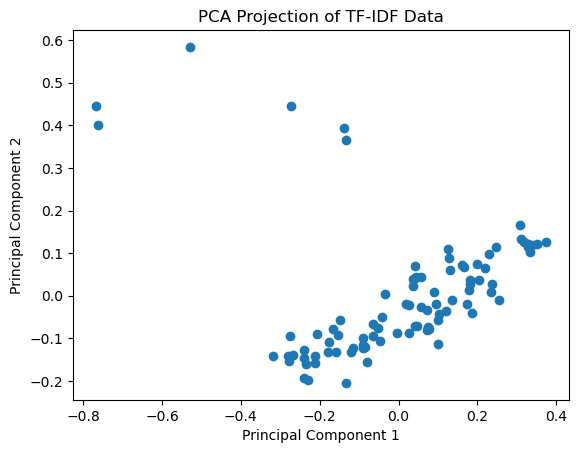

In [24]:
# Analyse de la répartition des données
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Appliquer PCA pour réduire à 2 dimensions
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(vec_combined)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1])
plt.title("PCA Projection of TF-IDF Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

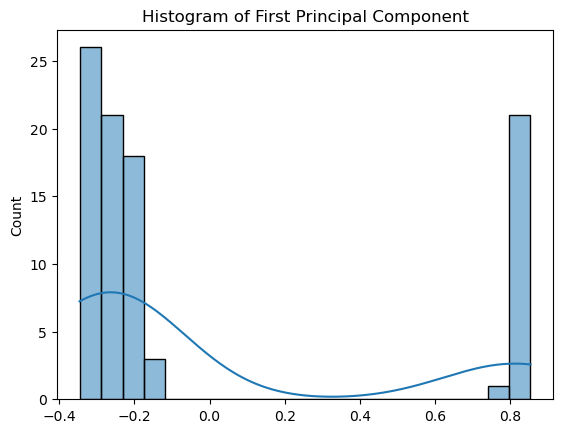

In [14]:
# Plot histograms of the principal components
sns.histplot(reduced_data[:, 0], kde=True)
plt.title('Histogram of First Principal Component')
plt.show()

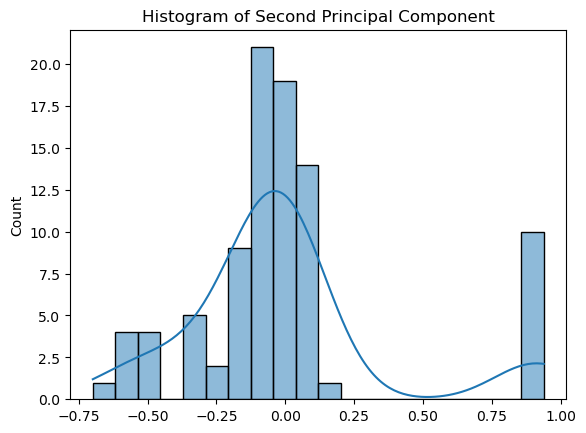

In [15]:
sns.histplot(reduced_data[:, 1], kde=True)
plt.title('Histogram of Second Principal Component')
plt.show()


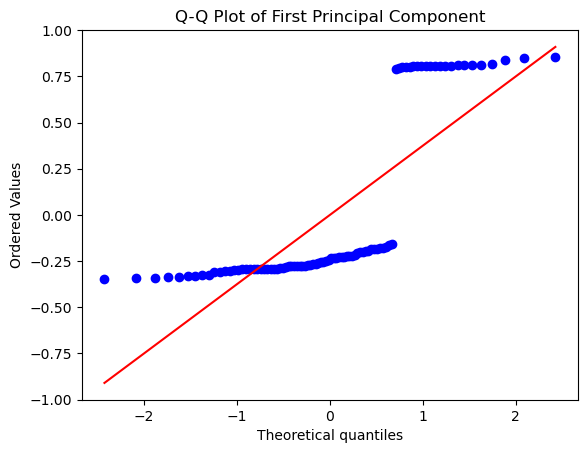

In [16]:
# Q-Q plots
import scipy.stats as stats
stats.probplot(reduced_data[:, 0], dist="norm", plot=plt)
plt.title('Q-Q Plot of First Principal Component')
plt.show()

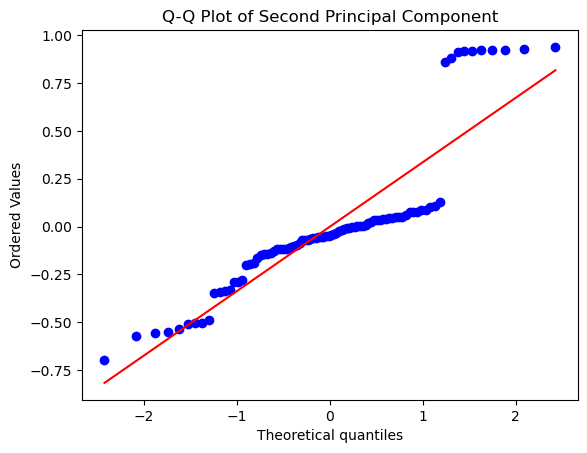

In [17]:
stats.probplot(reduced_data[:, 1], dist="norm", plot=plt)
plt.title('Q-Q Plot of Second Principal Component')
plt.show()

In [18]:
# Kolmogorov-Smirnov test for normality
stat1, p1 = kstest(reduced_data[:, 0], 'norm', args=(reduced_data[:, 0].mean(), reduced_data[:, 0].std()))
stat2, p2 = kstest(reduced_data[:, 1], 'norm', args=(reduced_data[:, 1].mean(), reduced_data[:, 1].std()))
print(f'Kolmogorov-Smirnov Test for First Principal Component: Statistics={stat1}, p-value={p1}')
print(f'Kolmogorov-Smirnov Test for Second Principal Component: Statistics={stat2}, p-value={p2}')


Kolmogorov-Smirnov Test for First Principal Component: Statistics=0.389684938794735, p-value=8.075298831908709e-13
Kolmogorov-Smirnov Test for Second Principal Component: Statistics=0.2652431549556761, p-value=4.442419072820334e-06


In [19]:
# Check if p-values are greater than 0.05 (common threshold)
df = df
if p1 > 0.05 and p2 > 0.05:
    print("Both principal components follow a Gaussian distribution. Proceeding with VBGMM.")
    
    # Create a VBGMM model
    vbgmm = BayesianGaussianMixture(n_components=6, covariance_type='full')
    
    # Fit the model to the data
    vbgmm.fit(reduced_data)
    
    # Predict the cluster for each sample
    labels = vbgmm.predict(reduced_data)
    
    df['Cluster'] = labels
    print(df)
    
    # Plot the clusters
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis')
    plt.title('Clusters of Books')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()
else:
    print("One or both principal components do not follow a Gaussian distribution. Consider transforming the data or using a different model.")

One or both principal components do not follow a Gaussian distribution. Consider transforming the data or using a different model.


In [34]:
"""from sklearn.metrics import silhouette_score
silhouette_scores = []
for n in range(2, 11):
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42).fit(vec)
    labels = gmm.predict(vec)
    score = silhouette_score(vec, labels)
    print(score)
    silhouette_scores.append(score)

plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()"""

TypeError: Sparse data was passed for X, but dense data is required. Use '.toarray()' to convert to a dense numpy array.